<a href="https://colab.research.google.com/github/quentincoded/Stochastics-and-Machine-Learning/blob/main/MNIST%20week14_problem1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this exercise we want to train an autoencoder for denoising the MNIST dataset and compare it with PCA denoising. You will need to implement the autoencoder and how it is trained.

First, we import the libraries and load the dataset:

In [8]:
import torch
import numpy as np
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader, Subset, random_split

# Seed for reproducibility
torch.manual_seed(1)
np.random.seed(1)

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# load the training and test datasets
train_data = MNIST(root='~/.pytorch/MNIST_data/', train=True, download=True, transform=transform)
test_data = MNIST(root='~/.pytorch/MNIST_data/', train=False, download=True, transform=transform)

# Create data loaders
train_loader = DataLoader(train_data, batch_size=256)
test_loader = DataLoader(test_data, batch_size=256)

These images are noise-free and we will use them to evaluate the efficiency of the denoising approaches. We need to create noisy images to use them in the training procedure. Let's define a function for adding a Gaussian noise to the images.

In [9]:
def add_noise(image_array, noise_factor=0.4):
    """Adds random noise to each image in the supplied array."""
    noisy_array = image_array + noise_factor * torch.randn_like(image_array)
    return torch.clamp(noisy_array, -1.0, 1.0)

Now, we want to use PCA for encoding images into a latent space and reconstruct them to get a denoised version of the images.

In [10]:
from sklearn.decomposition import PCA

# obtain one batch of test images
test_images, labels = next(iter(test_loader))

# Add noise
noisy_test_images = add_noise(test_images).view(test_images.shape[0], -1)
noisy_test_images_np = noisy_test_images.numpy()

# Apply PCA to reduce to 32 components
pca = PCA(n_components=32, random_state=42)
pca.fit(noisy_test_images_np)

PCA(n_components=32, random_state=42)

Now, we can transform and reconstruct the noisy test set. Since we used less components than the number of original features, we will get an approximation of the original set. Indeed, by dropping the components explaining variance in PCA the least, we hope to remove noise.

In [11]:
reconstructed_pca = pca.inverse_transform(pca.transform(noisy_test_images_np))

In [12]:
import matplotlib.pyplot as plt

def plot_digits(X, title):
    """Small helper function to plot 100 digits."""
    fig, axs = plt.subplots(nrows=10, ncols=10, figsize=(8, 8))
    for img, ax in zip(X, axs.ravel()):
        ax.imshow(img.reshape((28, 28)), cmap="binary")
        ax.axis("off")
    fig.suptitle(title, fontsize=24)

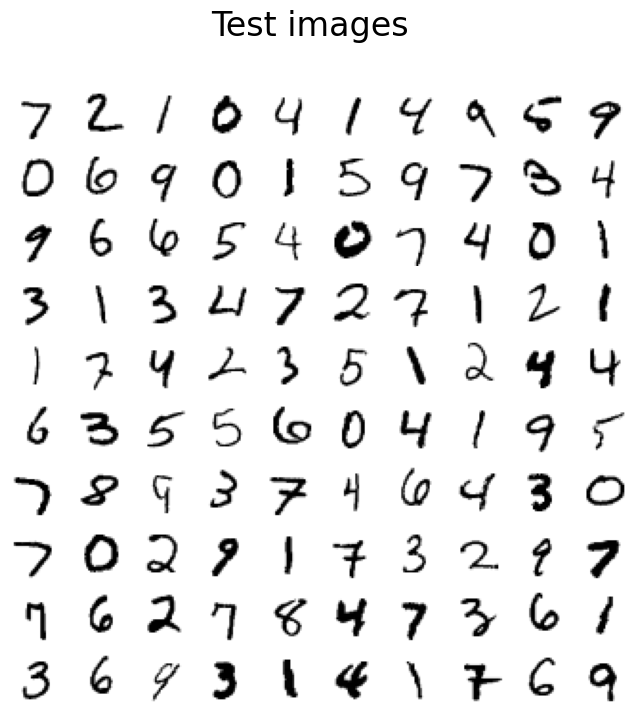

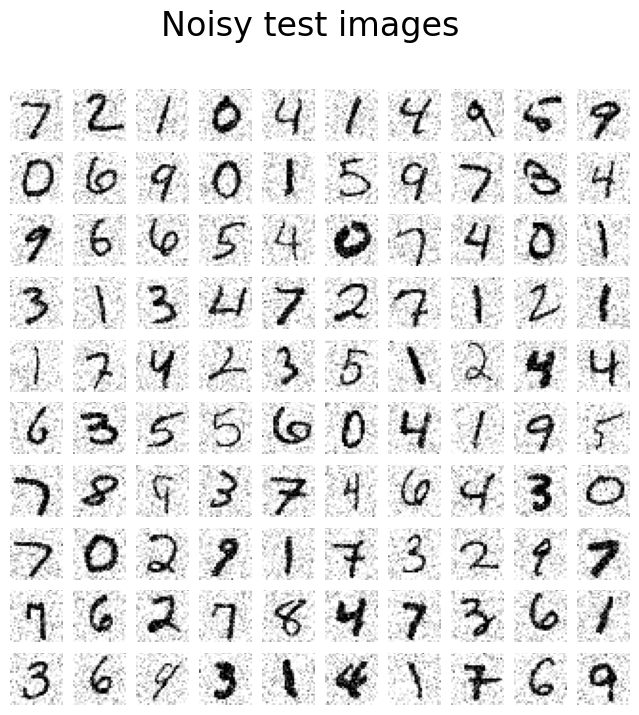

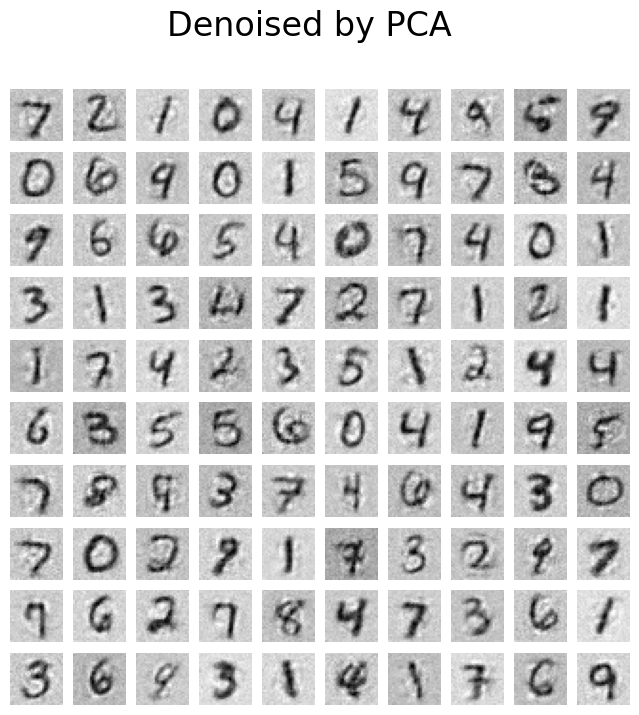

In [13]:
# Visualize the PCA results
plot_digits(test_images, "Test images")
plot_digits(noisy_test_images, "Noisy test images")
plot_digits(reconstructed_pca, "Denoised by PCA")

Now, we want to create an autoencoder. First, we have to define the network architecture. Then, define the forward path and the training update. You have to fill in the specified parts:

In [14]:
# Training Autoencoder:
# for faster training, select runtime-> change runtime type. Then select the GPU option.
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm.auto import tqdm

# Define the Autoencoder architecture
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32) # Compress to 32 features
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Tanh()
        )

    def forward(self, x):
        ##############################################
        # TO DO: complete the forward path
        x=self.encoder(x)
        x=self.decoder(x)
        ##############################################
        return x


# Determine if CUDA is available, and set PyTorch to use GPU or CPU accordingly
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

# Seed for reproducability
torch.manual_seed(1)

# Initialize the Autoencoder, Loss Function, and Optimizer
model = Autoencoder().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)


# Train the Autoencoder
epochs = 10
print("Training Started! IT MIGHT TAKE A FEW MINUTES!")
for epoch in range(epochs):
    for (images, _) in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs}"):

      # Flatten and add noise to the images
      images = images.view(images.size(0), -1).to(device)
      noisy_images = add_noise(images)

      loss = 0
      ##############################################
      # TO DO: complete the training update
      # 1. set gradients to zero
      # 2. compute the loss
      # 3. step the optimizer
      output = model(noisy_images)
      loss = nn.MSELoss()(output, images)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      ##############################################

    if (epoch+1) % 1 == 0:
      print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')


Using device: cuda
Training Started! IT MIGHT TAKE A FEW MINUTES!


Epoch 1/10:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 1/10, Loss: 0.1824183464050293


Epoch 2/10:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 2/10, Loss: 0.11888296157121658


Epoch 3/10:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 3/10, Loss: 0.10238756239414215


Epoch 4/10:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 4/10, Loss: 0.09328412264585495


Epoch 5/10:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 5/10, Loss: 0.08384218066930771


Epoch 6/10:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 6/10, Loss: 0.07789640128612518


Epoch 7/10:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 7/10, Loss: 0.07349605858325958


Epoch 8/10:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 8/10, Loss: 0.07142339646816254


Epoch 9/10:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 9/10, Loss: 0.06791087239980698


Epoch 10/10:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 10/10, Loss: 0.06574172526597977


In [15]:
# Save the weights
torch.save(model.state_dict(), './autoencoder.pt')

Now, we use the autoencoder to remove noise from test set images.

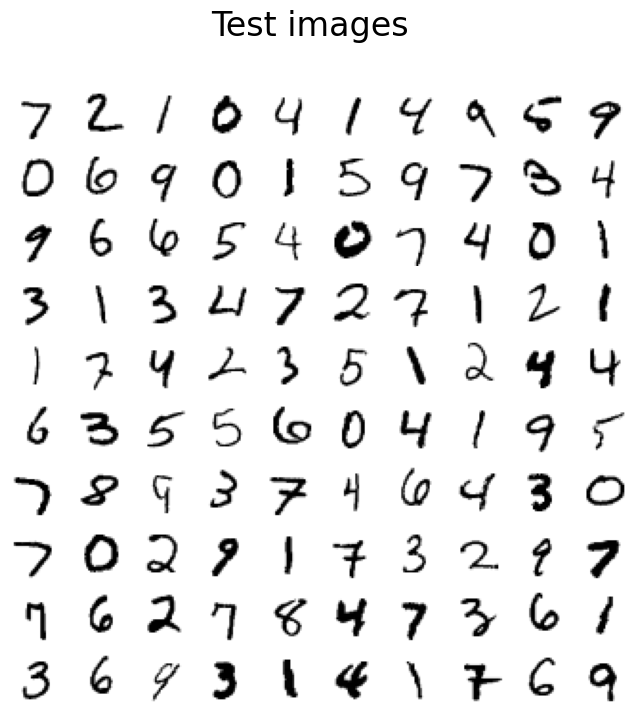

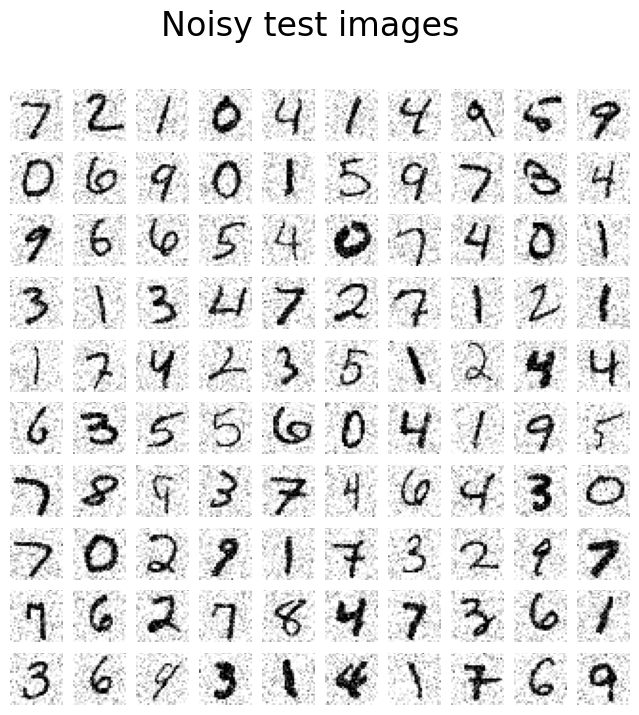

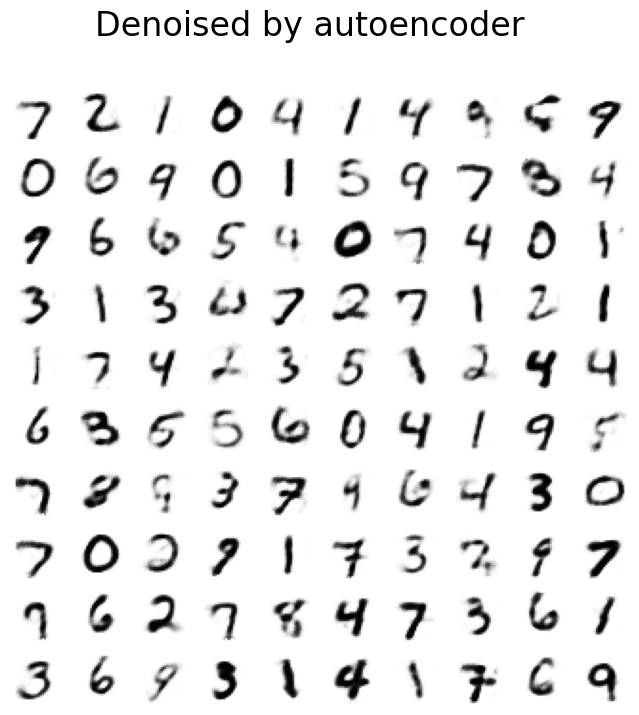

In [16]:
# Extract the latent space
with torch.no_grad():
    reconstructed_ae = model(noisy_test_images.to(device)).cpu().numpy()

# Visualize the Autoencoder results
plot_digits(test_images, "Test images")
plot_digits(noisy_test_images, "Noisy test images")
plot_digits(reconstructed_ae, "Denoised by autoencoder")